<a href="https://colab.research.google.com/github/gamma-opt/icnn/blob/main/example_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount git hub repo
!git clone https://github.com/gamma-opt/icnn.git


Cloning into 'icnn'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 117.99 KiB | 5.36 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
# install julia
%%shell
set -e
wget -nv https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh -O /tmp/install_colab.sh
bash /tmp/install_colab.sh  # Takes ~ 2 minutes

2024-11-21 14:52:17 URL:https://raw.githubusercontent.com/joaquimg/SBPO2024/main/install_colab.sh [1058/1058] -> "/tmp/install_colab.sh" [1]
Installing Julia 1.10.5 on the current Colab Runtime...
2024-11-21 14:52:19 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.5-linux-x86_64.tar.gz [173909866/173909866] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10


Now,
- go to the "Runtime" tab
- select "Change runtime type"
- select julia in the "Runtime type" dropdown
- click "save"

You might need to refresh the page.


In [ ]:
import Pkg
Pkg.add("Gogeta")
Pkg.add("JuMP")
Pkg.add("Plots")
Pkg.add("JSON")
Pkg.add("Alpine")
Pkg.add("HiGHS")
Pkg.add("Juniper")
Pkg.add("Ipopt")

In [1]:
using Gogeta
using Plots
using JSON
using IJulia

In [2]:
include("../../src/bound.jl")
include("../../src/branch.jl")
include("../../src/envelope.jl")
include("../../src/solver.jl")
include("../../src/util.jl")

branch_and_bound (generic function with 1 method)

In [3]:
# replace with the path to the model_weights.json file
file_path = "model_weights_2D.json"

# Read the JSON file
json_content = read(file_path, String)

# Parse the JSON content
parsed_json = JSON.parse(json_content)

Dict{String, Any} with 3 entries:
  "FC2"   => Any[Any[Any[0.667317], Any[1.52441]], Any[-2.1556]]
  "SKIP2" => Any[Any[Any[-2.07353]]]
  "FC1"   => Any[Any[Any[-2.05871, 1.12061]], Any[-0.948954, 2.04866]]

In [4]:
# define the icnn model
icnn_lp =  Model(alpine_optimiser)

# define the output variable
icnn_output_var = @variable(icnn_lp, z, base_name="output_var")

# define the input variable
icnn_input_var = @variable(icnn_lp, x[1:1], base_name="input_var")

# define the objective function
@objective(icnn_lp, Min, 0)

# add variables, constraints, and an objective function to the icnn_lp model to account for the generated ICNN.
ICNN_incorporate!(icnn_lp, file_path, icnn_output_var, icnn_input_var...)

output_var

In [5]:
print(icnn_lp)

Min output_var
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348


In [5]:
# initial setup
lb = [-3.0]
ub = [3.0]
box = Box(1, lb, ub)

Box(1, [-3.0], [3.0])

In [6]:
#---------------------------Out ICNN-----------------------------------------------#
# define the outter jump model
out_icnn_lp = copy(icnn_lp)
set_optimizer(out_icnn_lp, alpine_optimiser)

# define the objective
@objective(out_icnn_lp, Min, 0)

# define the constraints on input variable
for i in 1:box.n
    @constraint(out_icnn_lp, out_icnn_lp[:x][i] >= box.lb[i])  # Lower bound constraint
    @constraint(out_icnn_lp, out_icnn_lp[:x][i] <= box.ub[i])  # Upper bound constraint
end


In [8]:
print(out_icnn_lp)

Min 0
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 input_var[1] <= 3


# Without BB

## Example 1: max x, s.t. z >= 2 (feasibility)

In [14]:
#---------------------------Example 1----------------------------------------------#

out_icnn_lp_exm1 = copy(out_icnn_lp)
set_optimizer(out_icnn_lp_exm1, alpine_optimiser)

# add contraint on the output variable
@constraint(out_icnn_lp_exm1, exm_1, out_icnn_lp_exm1[:z] >= 2)

# define the objective
@objective(out_icnn_lp_exm1, Max, out_icnn_lp_exm1[:x][1] - out_icnn_lp_exm1[:z])  # penalty trem added

# optimize the outter jump model
optimize!(out_icnn_lp_exm1)


*** Alpine ended with status OPTIMAL ***


In [16]:
println(out_icnn_lp)

Min 0
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 input_var[1] <= 3



In [15]:
# save the input and output values
x_optimal = value.(out_icnn_lp_exm1[:x])
out_z_optimal = value.(out_icnn_lp_exm1[:z])

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

println("x value: ", x_optimal)
println("z value: ", out_z_optimal)
println("icnn(x) value: ", icnn_z_optimal)


*** Alpine ended with status OPTIMAL ***
x value: [3.0]
z value: 2.0
icnn(x) value: -0.1284143



*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

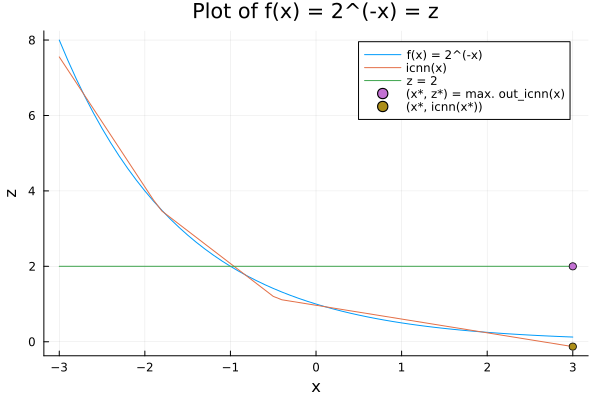

In [17]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

plot!(x_values, 2*ones(length(x_values)), label="z = 2")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*))")

## Example 2: max x+z (penalty domination)

In [22]:
#---------------------------Example 2---------------------------------------------#
out_icnn_lp_exm2 = copy(out_icnn_lp)
set_optimizer(out_icnn_lp_exm2, alpine_optimiser)

# define the objective
@objective(out_icnn_lp_exm2, Max, out_icnn_lp_exm2[:x][1]+out_icnn_lp_exm2[:z] - out_icnn_lp_exm2[:z])

# optimize the outter jump model
optimize!(out_icnn_lp_exm2)


*** Alpine ended with status OPTIMAL ***


In [24]:
println(out_icnn_lp_exm2)

Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 input_var[1] <= 3



In [25]:
# save the input and output values
x_optimal = value.(out_icnn_lp_exm2[:x])
out_z_optimal = value.(out_icnn_lp_exm2[:z])
icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

println("x value: ", x_optimal)
println("z value: ", out_z_optimal)
println("icnn(x) value: ", icnn_z_optimal)


*** Alpine ended with status OPTIMAL ***
x value: [3.0]
z value: 163216.7377777
icnn(x) value: -0.1284143



*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

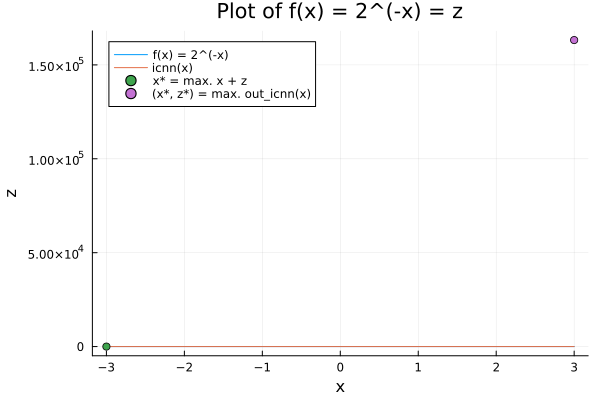

In [26]:
# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="Plot of f(x) = 2^(-x) = z")

#forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# calculate x+z values
xz = x_values .+ icnn

max_ind = findfirst(x -> x == maximum(xz), xz)
scatter!([x_values[max_ind]], [icnn[max_ind]], label="x* = max. x + z")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*) = max. out_icnn(x)")

# Using B&B

## max x, s.t. z >= 2
True optimum: x = -1, z = 2 , objective = -1

Initial setup

In [7]:
lb = [-3.0]
ub = [3.0]
box = Box(1, lb, ub)

Box(1, [-3.0], [3.0])

In [8]:
tree_status = TreeStatus(
    -Inf,           # obj_lb: lower bound on the objective function
    nothing,        # x_optimal: optimal x values found so far
    [(box, 1)],  # bounds_to_branch: boxes to branch on, branching on dimension 1
    false           # all_pruned: flag to indicate if all branches are pruned
)

TreeStatus(-Inf, nothing, Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)], false)

### step-by-step

Level 0 root:

In [9]:
root_icnn_lp = copy(icnn_lp)
set_optimizer(root_icnn_lp, alpine_optimiser)

# define the constraints on input variable
for i in 1:box.n
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] >= box.lb[i])  # Lower bound constraint
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] <= box.ub[i])  # Upper bound constraint
end

# add additional contraint on the output variable
@constraint(root_icnn_lp, root_icnn_lp[:z] >= 2)

# overwrite the objective
@objective(root_icnn_lp, Max, root_icnn_lp[:x][1])

input_var[1]

In [12]:
print(root_icnn_lp)

Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 output_var >= 2
 input_var[1] <= 3


In [10]:
results = solve_node_models([root_icnn_lp], icnn_lp)
tree_status = process_results(results, tree_status)


----- Optimising Model 1 -----

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: 3.0000000274935252
        x value: [3.0]
        z value: 108078.0213728
  icnn(x) value: -0.1284143
           Gap: 841636.404879363

Processing result for model 1 with box: Box(1, [-3.0], [3.0]), dimension: 1
...Further branching on box Box(1, [-3.0], [3.0]) with dimension 1 is required

Summary:

Further branching on Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)] is required

Current lower bound: -Inf


TreeStatus(-Inf, nothing, Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)], false)

Level 1:

In [11]:
tree_status.bounds_to_branch= branch_box(tree_status.bounds_to_branch)

new_icnn_lp_list = generate_relaxation(icnn_lp, root_icnn_lp, tree_status)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 output_var >= 2
 input_var[1] >= -3
 input_var[1] <= 3
 input_var[1] <= 0
 constraint_3 : output_var - 7.5531774 a[1] - 0.9673938 a[2] <= 0
 a[1] >= 0
 a[2] >= 0
Model 1 created successfully

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] - 3 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] +

2-element Vector{Model}:
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z

In [12]:
results = solve_node_models(new_icnn_lp_list, icnn_lp)

tree_status = process_results(results, tree_status)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -0.4703796436426952
        x value: [-0.4703796]
        z value: 2.0
  icnn(x) value: 1.1521704
           Gap: 0.7358543493219407

----- Optimising Model 2 -----

*** Alpine ended with status INFEASIBLE ***
Status: INFEASIBLE
Optimisation did not reach optimality

Processing result for model 1 with box: Box(1, [-3.0], [0.0]), dimension: 1
...Further branching on box Box(1, [-3.0], [0.0]) with dimension 1 is required

Processing result for model 2 with box: Box(1, [0.0], [3.0]), dimension: 1
...Current branch on box Box(1, [0.0], [3.0]) with dimension 1 is pruned by infeasibility

Summary:

Further branching on Tuple{Box, Int64}[(Box(1, [-3.0], [0.0]), 1)] is required

Current lower bound: -Inf


┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:259
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:559


TreeStatus(-Inf, nothing, Tuple{Box, Int64}[(Box(1, [-3.0], [0.0]), 1)], false)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

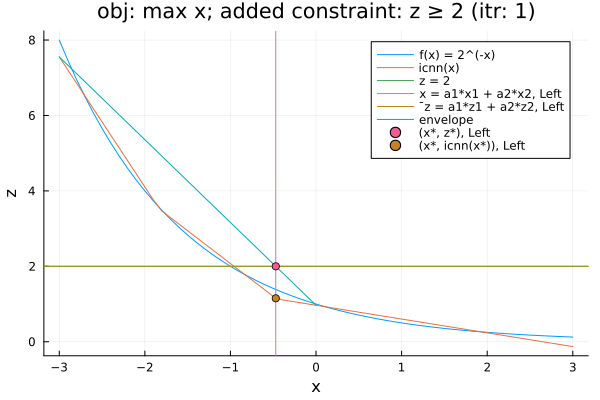

In [17]:
# define the branching sets
extreme_points = [[-3, 0],[0,3]]

# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x; added constraint: z ≥ 2 (itr: 1)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Left")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Left")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Left")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Left")
     

Level 2:

In [13]:
tree_status.bounds_to_branch= branch_box(tree_status.bounds_to_branch)

new_icnn_lp_list = generate_relaxation(icnn_lp, root_icnn_lp, tree_status)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 3 a[1] + 1.5 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 output_var >= 2
 input_var[1] >= -3
 input_var[1] <= 3
 input_var[1] <= -1.5
 constraint_3 : output_var - 7.5531774 a[1] - 2.9427679 a[2] <= 0
 a[1] >= 0
 a[2] >= 0
Model 1 created successfully

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 1.5 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605

2-element Vector{Model}:
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z

In [14]:
results = solve_node_models(new_icnn_lp_list, icnn_lp)

tree_status = process_results(results, tree_status)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -1.499999998810203
        x value: [-1.5]
        z value: 2.9427679
  icnn(x) value: 2.9427679
           Gap: 0.0

----- Optimising Model 2 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -0.7841093315172879
        x value: [-0.7841093]
        z value: 2.0
  icnn(x) value: 1.6977731
           Gap: 0.17801371690952103

Processing result for model 1 with box: Box(1, [-3.0], [-1.5]), dimension: 1
...Updated lower bound: -1.499999998810203

Processing result for model 2 with box: Box(1, [-1.5], [0.0]), dimension: 1
...Further branching on box Box(1, [-1.5], [0.0]) with dimension 1 is required

Summary:

Further branching on Tuple{Box, Int64}[(Box(1, [-1.5], [0.0]), 1)] is required

Current lower bound: -1.499999998810203


TreeStatus(-1.499999998810203, [-1.5], Tuple{Box, Int64}[(Box(1, [-1.5], [0.0]), 1)], false)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTI

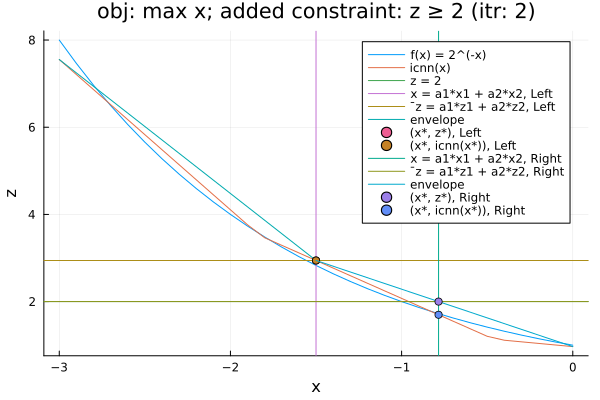

In [20]:
# define the new branching sets
extreme_points = [[-3, -1.5],[-1.5, 0]]

# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", 
    title="obj: max x; added constraint: z ≥ 2 (itr: 2)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Left")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Left")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Left")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Left")

# Get the results for model 2
model_result = results[2]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[2]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Right")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Right")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Right")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Right")

Level 3:

In [15]:
tree_status.bounds_to_branch= branch_box(tree_status.bounds_to_branch)

new_icnn_lp_list = generate_relaxation(icnn_lp, root_icnn_lp, tree_status)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 1.5 a[1] + 0.75 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 output_var >= 2
 input_var[1] >= -1.5
 input_var[1] <= 3
 input_var[1] <= -0.75
 constraint_3 : output_var - 2.9427679 a[1] - 1.6384541 a[2] <= 0
 a[1] >= 0
 a[2] >= 0
Model 1 created successfully

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 0.75 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1

2-element Vector{Model}:
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z
 A JuMP Model
├ solver: Alpine
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 8
├ num_constraints: 17
│ ├ AffExpr in MOI.EqualTo{Float64}: 4
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8
│ ├ AffExpr in MOI.LessThan{Float64}: 3
│ └ VariableRef in MOI.GreaterThan{Float64}: 2
└ Names registered in the model
  └ :a, :constraint_3, :constraint_4, :x, :z

In [16]:
results = solve_node_models(new_icnn_lp_list, icnn_lp)

tree_status = process_results(results, tree_status)


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -0.9578943030527332
        x value: [-0.9578943]
        z value: 2.0
  icnn(x) value: 1.9999999
           Gap: 5.000000252919349e-8

----- Optimising Model 2 -----

*** Alpine ended with status INFEASIBLE ***
Status: INFEASIBLE
Optimisation did not reach optimality

Processing result for model 1 with box: Box(1, [-1.5], [-0.75]), dimension: 1
...Updated lower bound: -0.9578943030527332

Processing result for model 2 with box: Box(1, [-0.75], [0.0]), dimension: 1
...Current branch on box Box(1, [-0.75], [0.0]) with dimension 1 is pruned by infeasibility

Summary:

All nodes are pruned, no further branching needed

Optimal solution found:
      x values: [-0.9578943]
solution value: -0.9578943030527332


┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:259
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:559


TreeStatus(-0.9578943030527332, [-0.9578943], Tuple{Box, Int64}[], true)

All nodes are pruned, no further branching needed

`x values: [-0.9578943]`

`solution value: -0.9578943030527332`


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***


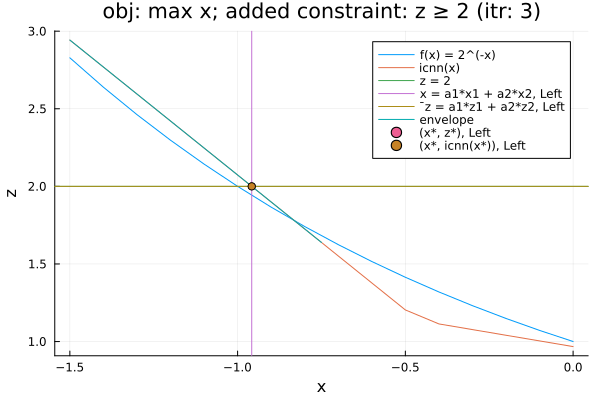

In [23]:
# define the new branching sets
extreme_points = [[-1.5, -0.75],[-0.75, 0]]

# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -1.5:0.1:0
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", 
    title="obj: max x; added constraint: z ≥ 2 (itr: 3)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

hline!([2], label="z = 2")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Left")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Left")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Left")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Left")

### capsuled

In [17]:
lb = [-3.0]
ub = [3.0]
box = Box(1, lb, ub)

Box(1, [-3.0], [3.0])

In [18]:
tree_status = TreeStatus(
    -Inf,           # obj_lb: lower bound on the objective function
    nothing,        # x_optimal: optimal x values found so far
    [(box, 1)],  # bounds_to_branch: boxes to branch on, branching on dimension 1
    false           # all_pruned: flag to indicate if all branches are pruned
)

TreeStatus(-Inf, nothing, Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)], false)

In [19]:
x_optimal, obj_optimal = branch_and_bound(icnn_lp, root_icnn_lp, tree_status)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 output_var >= 2
 input_var[1] >= -3
 input_var[1] <= 3
 input_var[1] <= 0
 constraint_3 : output_var - 7.5531774 a[1] - 0.9673938 a[2] <= 0
 a[1] >= 0
 a[2] >= 0
Model 1 created successfully

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] - 3 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] +

┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:259
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:559



*** Alpine ended with status OPTIMAL ***
Objective value: -1.499999998810203
        x value: [-1.5]
        z value: 2.9427679
  icnn(x) value: 2.9427679
           Gap: 0.0

----- Optimising Model 2 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: -0.7841093315172879
        x value: [-0.7841093]
        z value: 2.0
  icnn(x) value: 1.6977731
           Gap: 0.17801371690952103

Processing result for model 1 with box: Box(1, [-3.0], [-1.5]), dimension: 1
...Updated lower bound: -1.499999998810203

Processing result for model 2 with box: Box(1, [-1.5], [0.0]), dimension: 1
...Further branching on box Box(1, [-1.5], [0.0]) with dimension 1 is required

Summary:

Further branching on Tuple{Box, Int64}[(Box(1, [-1.5], [0.0]), 1)] is required

Current lower bound: -1.499999998810203

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1]
Subject to
 -input_var[1] + _[3]

┌ Warning:  Warning: Presolve ends with local solver yielding OTHER_ERROR.
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:259
┌ Warning:   Warning: Infeasibility detected in the MIP solver
└ @ Alpine C:\Users\liuy43\.julia\packages\Alpine\BQG51\src\main_algorithm.jl:559


([-0.9578943], -0.9578943030527332)

## max x+z
True optimum: x = -3, z = 8 , objective = 5

In [26]:
lb = [-3.0]
ub = [3.0]
box = Box(1, lb, ub)

Box(1, [-3.0], [3.0])

In [27]:
tree_status = TreeStatus(
    -Inf,           # obj_lb: lower bound on the objective function
    nothing,        # x_optimal: optimal x values found so far
    [(box, 1)],  # bounds_to_branch: boxes to branch on, branching on dimension 1
    false           # all_pruned: flag to indicate if all branches are pruned
)

TreeStatus(-Inf, nothing, Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)], false)

In [28]:
root_icnn_lp = copy(icnn_lp)
set_optimizer(root_icnn_lp, alpine_optimiser)

# define the constraints on input variable
for i in 1:box.n
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] >= box.lb[i])  # Lower bound constraint
    @constraint(root_icnn_lp, root_icnn_lp[:x][i] <= box.ub[i])  # Upper bound constraint
end

# overwrite the objective
@objective(root_icnn_lp, Max, root_icnn_lp[:x][1]+ root_icnn_lp[:z])

input_var[1] + output_var

In [53]:
print(root_icnn_lp)

Max input_var[1] + output_var
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 input_var[1] <= 3


In [23]:
x_optimal, obj_optimal = branch_and_bound(icnn_lp, root_icnn_lp, tree_status)


*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1] + output_var
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643 _[5] + _[6] >= -2.1556038856506348
 input_var[1] >= -3
 input_var[1] >= -3
 input_var[1] <= 3
 input_var[1] <= 0
 constraint_3 : output_var - 7.5531774 a[1] - 0.9673938 a[2] <= 0
 a[1] >= 0
 a[2] >= 0
Model 1 created successfully

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1] + output_var
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] - 3 a[2] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.1206057071685

([-3.0], 4.553177442689749)

In [25]:
results

2-element Vector{Any}:
 NodeOptResult(1, MathOptInterface.OPTIMAL, -0.9578943030527332, [-0.9578943], 2.0, [0.2771924, 0.7228076], 1.9999999, 5.000000252919349e-8, true, true)
 NodeOptResult(2, MathOptInterface.INFEASIBLE, NaN, nothing, NaN, nothing, NaN, NaN, false, true)

All nodes are pruned, no further branching needed

`x values: [-3.0]`

`solution value: 4.553177442689749`


----- Optimising Model 1 -----

*** Alpine ended with status OPTIMAL ***
Status: OPTIMAL

*** Alpine ended with status OPTIMAL ***
Objective value: 1.0000030001000224e6
        x value: [3.0]
        z value: 1.0000000001e6
  icnn(x) value: -0.1284143
           Gap: 7.787295717955866e6

Processing result for model 1 with box: Box(1, [-3.0], [3.0]), dimension: 1
...Further branching on box Box(1, [-3.0], [3.0]) with dimension 1 is required

Summary:

Further branching on Tuple{Box, Int64}[(Box(1, [-3.0], [3.0]), 1)] is required

Current lower bound: -Inf

*** Alpine ended with status OPTIMAL ***

*** Alpine ended with status OPTIMAL ***
Max input_var[1] + output_var
Subject to
 -input_var[1] + _[3] == 0
 output_var - _[6] == 0
 input_var[1] + 3 a[1] == 0
 constraint_4 : a[1] + a[2] == 1
 _[4] >= 0
 _[5] >= 0
 2.0587143898010254 _[3] + _[4] >= -0.9489541053771973
 -1.120605707168579 _[3] + _[5] >= 2.0486631393432617
 2.0735292434692383 _[3] - 0.667317271232605 _[4] - 1.5244076251983643

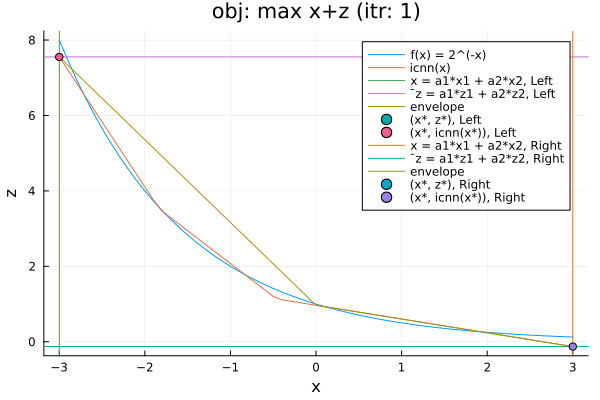

In [29]:
results = solve_node_models([root_icnn_lp], icnn_lp)
tree_status = process_results(results, tree_status)
tree_status.bounds_to_branch= branch_box(tree_status.bounds_to_branch)
new_icnn_lp_list = generate_relaxation(icnn_lp, root_icnn_lp, tree_status)
results = solve_node_models(new_icnn_lp_list, icnn_lp)
tree_status = process_results(results, tree_status)

# define the branching sets
extreme_points = [[-3, 0],[0,3]]

# Define the function f(x) = 2^(-x)
f(x) = 2^(-x)

# Generate data for plotting
x_values = -3:0.1:3
y_values = f.(x_values)

# Get the results for model 1
model_result = results[1]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Plot the function
plot(x_values, y_values, label="f(x) = 2^(-x)", xlabel="x", ylabel="z", title="obj: max x+z (itr: 1)")

# forward pass x_values to the icnn model
icnn = forwardpass.(icnn_lp, x_values)
# Plot the function
plot!(x_values, icnn, label="icnn(x)")

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[1]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Left")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Left")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Left")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Left")

# Get the results for model 2
model_result = results[2]
x_optimal = model_result.x_optimal
out_z_optimal = model_result.z_optimal
a_values = model_result.a_values

icnn_z_optimal = forwardpass(icnn_lp, x_optimal)

# Calculate the weighted sum for x - Constraint 2: x = sum(ai * extreme_points_i))
ext_points = extreme_points[2]
weighted_x = sum(a_values[i] * ext_points[i] for i in 1:length(ext_points))
# Calculate the weighted sum for z - Constraint 3: z_k <= sum(ai * forwardpass(icnn_lp, extreme_points_i))
weighted_z = sum(a_values[i] * forwardpass(icnn_lp, ext_points[i]) for i in 1:length(ext_points))


vline!([weighted_x], label="x = a1*x1 + a2*x2, Right")
hline!([weighted_z], label="̄z = a1*z1 + a2*z2, Right")

plot!(ext_points, [forwardpass(icnn_lp, pt) for pt in ext_points], label="envelope")

scatter!([x_optimal], [out_z_optimal], label="(x*, z*), Right")
scatter!([x_optimal], [icnn_z_optimal], label="(x*, icnn(x*)), Right")